In [1]:
!pip install opencc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.4 MB/s eta 0:00:0000:0100:01


In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random
from opencc import OpenCC

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
from torch.utils.data import random_split

import matplotlib.pyplot as plt
# plt.switch_backend('agg')
import time
import math
import matplotlib.ticker as ticker
import numpy as np
import time
import json

import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable


# print(torch.cuda.device_count())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
SOS_token = 1
EOS_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"<UNK>": 3}
        self.word2count = {}
        self.index2word = {1: "SOS", 2: "EOS", 3: "<UNK>"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        # print(sentence)
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters but keep numbers and some punctuation
def normalizeEn(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

def normalizeCh(s):
    cc = OpenCC('t2s')  ##Traditional Chinese --> Simplified
    s = cc.convert(s) 
    s = s.replace(" ", "")
    s = re.findall(r'[\u4e00-\u9fa5]', s)
    s =  ' '.join(s)
    return s

In [4]:
s = "幾年前，我們的房間裡沒有什麼家具。"
normalizeCh(s)

'几 年 前 我 们 的 房 间 里 没 有 什 么 家 具'

In [5]:
def clean_file(input_path, output_path):
    with open(input_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    cleaned_lines = []
    # print(len(lines))
    for line in lines:
        parts = line.strip().split('\t')
        if len(parts) >= 2:
            en = parts[0].strip()
            zh = parts[1].strip()
            cleaned_lines.append(f"{en}\t{zh}")
    # print(parts)
    # print(len(cleaned_lines))
    with open(output_path, 'w', encoding='utf-8') as f:
        for line in cleaned_lines:
            f.write(line + '\n')



def readLangs(lang1, lang2, ratio, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('/kaggle/working/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')
    # lines = lines[:10000]
    random.seed(9)
    n_lines = len(lines)
    split_point = int(n_lines * ratio)
    random.shuffle(lines) #shuffle data and then split

    # Split every line into pairs and normalize
    train_pairs = []
    test_pairs = []

    global MAX_LENGTH
    MAX_LENGTH = 0
    
    for idx, l in enumerate(lines):
        each = l.split('\t')
        s1, s2 = normalizeEn(each[0]), normalizeCh(each[1])
        line_pair = [s1, s2]

        if idx < split_point:
            tmp1 = len(s1.split())
            tmp2 = len(s2.split())
            max_l = max(tmp1, tmp2)
            if max_l > MAX_LENGTH:
                MAX_LENGTH = max_l
            train_pairs.append(line_pair)

            if (idx + 1) % 10000 == 0:
                print(f"Processed {idx + 1} lines")
                print(train_pairs[-1])
        else:
            test_pairs.append(line_pair)

    # Reverse pairs, make Lang instances
    if reverse:
        train_pairs = [list(reversed(p)) for p in train_pairs]
        test_pairs = [list(reversed(p)) for p in test_pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, train_pairs, test_pairs

In [6]:
def prepareData(lang1, lang2, ratio, reverse=True):
    input_lang, output_lang, train_pairs, test_pairs = readLangs(lang1, lang2, ratio, reverse)
    print("Read %s training sentence pairs" % len(train_pairs))
    # print("Counting words...")

    for pair in train_pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])

    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, train_pairs, test_pairs

# clean_file('cmn.txt', 'eng-cmn.txt')
# input_lang, output_lang, pairs = prepareData('eng', 'cmn', True)
# print(random.choice(pairs))

In [7]:
def indexesFromSentence(lang, sentence):
    # return [lang.word2index[word] for word in sentence.split(' ')]
    return [lang.word2index.get(word, lang.word2index["<UNK>"]) for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size, ratio):
    input_lang, output_lang, train_pairs, test_pairs = prepareData('eng', 'cmn', ratio, True)

    n = len(train_pairs)

    input_ids = np.zeros((n, MAX_LENGTH+1), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH+1), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(train_pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids
        if (idx+1) % 10000 == 0:
            print(inp, inp_ids)
            print(tgt, tgt_ids)
            

    train_dataset = TensorDataset(torch.LongTensor(input_ids).to(device),
                                 torch.LongTensor(target_ids).to(device))

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
    # test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    return input_lang, output_lang, train_dataloader, test_pairs


In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden
    
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH+1):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1) 
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

In [9]:
def showPlot(losses):
    plt.figure(figsize=(8,5))
    plt.plot(np.arange(len(losses))+1, losses)
    plt.xlabel("Epoch")
    plt.ylabel("Training Loss")
    plt.grid()

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)
    
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001, print_every = 5):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  
    plot_loss_total = 0  

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        # plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))
            # print(f'%.4f' % (print_loss_avg))


        plot_losses.append(loss)

    # showPlot(plot_losses)
    return plot_losses

In [11]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        # print(input_tensor)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        # print(encoder_outputs)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn
    
# print(test_data)
# sentence = "我 喜 欢 吃 鸡 蛋"
# output_words, _ = evaluate(encoder, decoder, sentence, input_lang, output_lang)
# print(' '.join(output_words))

def evaluateOutput(encoder, decoder, test_pairs, n):
    output = {}
    for i in range(n):
        pair = test_pairs[i]#random.choice(test_pairs)
        output_words, attentions = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
    
        # output_sentence = ' '.join(output_words)
        output[i] = [pair[0], pair[1], output_words, attentions.tolist()]
        # if i % 300 == 0:
        #     print('>', pair[0])
        #     print('=', pair[1])
        #     print('<', output_sentence)
    
    return output

In [12]:
clean_file('/kaggle/input/trans-data/cmn.txt', 'eng-cmn.txt')
hidden_size = 256
batch_size = 64
input_lang, output_lang, train_dataloader, test_data = get_dataloader(batch_size,ratio=0.9)

Reading lines...
Processed 10000 lines
['i want a boat', '我 想 要 一 艘 船']
Processed 20000 lines
['we made pancakes for breakfast', '我 们 早 餐 做 了 煎 饼']
Read 26918 training sentence pairs
Counted words:
cmn 2707
eng 6760
我 想 要 一 艘 船 [18, 31, 117, 58, 1651, 921, 2]
i want a boat [23, 289, 42, 3113, 2]
我 们 早 餐 做 了 煎 饼 [18, 19, 209, 880, 108, 6, 2564, 2116, 2]
we made pancakes for breakfast [16, 8, 5999, 256, 1151, 2]


3m 4s (- 58m 30s) (5 5%) 0.5992
6m 6s (- 54m 54s) (10 10%) 0.2423
9m 6s (- 51m 37s) (15 15%) 0.1268
12m 9s (- 48m 37s) (20 20%) 0.0809
15m 27s (- 46m 21s) (25 25%) 0.0584
18m 57s (- 44m 13s) (30 30%) 0.0465
22m 19s (- 41m 27s) (35 35%) 0.0395
25m 45s (- 38m 37s) (40 40%) 0.0350
29m 7s (- 35m 35s) (45 45%) 0.0320
32m 26s (- 32m 26s) (50 50%) 0.0297
35m 47s (- 29m 16s) (55 55%) 0.0282
39m 10s (- 26m 7s) (60 60%) 0.0271
42m 36s (- 22m 56s) (65 65%) 0.0262
45m 59s (- 19m 42s) (70 70%) 0.0253
49m 22s (- 16m 27s) (75 75%) 0.0246
52m 28s (- 13m 7s) (80 80%) 0.0240
55m 28s (- 9m 47s) (85 85%) 0.0233
58m 26s (- 6m 29s) (90 90%) 0.0232
61m 25s (- 3m 13s) (95 95%) 0.0227
64m 24s (- 0m 0s) (100 100%) 0.0224


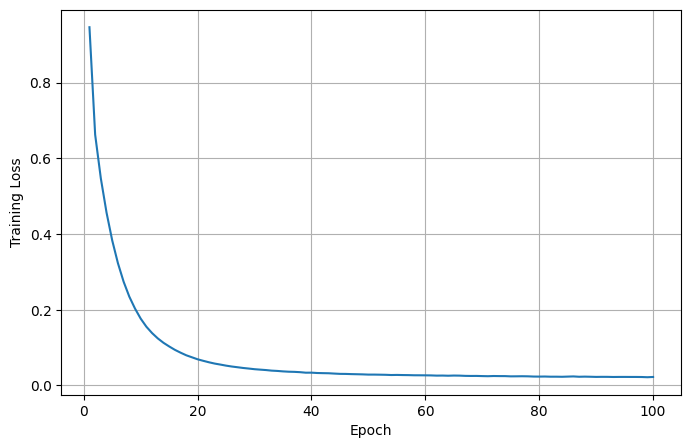

In [13]:
Encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
Decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train_loss = train(train_dataloader, Encoder, Decoder, 100, print_every=5)
showPlot(train_loss)

In [15]:
Encoder.eval()
Decoder.eval()
output = evaluateOutput(Encoder, Decoder, test_data, len(test_data))

# save first for later work
with open("eval_output.json", "w",encoding='utf-8') as f:
    json.dump(output, f,ensure_ascii=False, indent=4)

In [27]:
def showAttention(input_sentence, output_words, attentions):
    rcParams['font.sans-serif'] = ['SimHei'] 
    rcParams['axes.unicode_minus'] = False
        
    fig, ax = plt.subplots(figsize =(8,6))
    
    im = ax.matshow(attentions, cmap = 'bone')
    # fig.colorbar(cax)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = plt.colorbar(im, cax=cax)
    
    input_tokens = input_sentence.split(" ") + ['<EOS>']
    output_tokens = output_words       
    # print(input_tokens)
    ax.set_xticks(range(len(input_tokens)))
    ax.set_xticklabels(input_tokens)
    
    ax.set_yticks(range(len(output_tokens)))
    ax.set_yticklabels(output_tokens)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.tight_layout()
    plt.show()



def evaluateAndShowAttention(input_sentence, output_words, ground_true, attentions, if_show):
    # output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    print("ground truth =", ground_true)
    if if_show:
        showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])

In [25]:
with open("eval_output.json", "r",encoding='utf-8') as f:
    data = json.load(f)

idx = random.choices(range(len(data)),k=5)
for i in idx:
    print(str(i), data[str(i)][:3])

73 ['我 们 试 著 阻 止 你', 'we tried to stop you', ['we', 'tried', 'to', 'stop', '<EOS>']]
2216 ['如 果 你 有 一 万 美 元 你 想 做 什 么 呢', 'what would you do if you had ten thousand dollars ?', ['what', 'you', 'do', '?', '<EOS>']]
1730 ['汤 姆 是 个 骗 子', 'tom is deceitful', ['tom', 's', 'an', 'idiot', '<EOS>']]
607 ['昨 天 晚 上 六 点 钟 我 们 来 到 了 这 里', 'we arrived here at six yesterday evening', ['come', 'back', 'late', 'at', 'six', 'tomorrow', 'morning', '<EOS>']]
341 ['在 墨 西 哥 有 很 多 贫 民 窟', 'there are many slums in mexico', ['there', 'were', 'many', 'passengers', 'in', 'that', 'a', 'lot', 'of', 'death', '<EOS>']]


input = 汤 姆 去 了 玛 丽 家
output = tom went over mary s house <EOS>
ground truth = tom went to mary s

input = 汤 姆 病 了
output = tom sick <EOS>
ground truth = tom s sick

input = 那 条 新 裙 子 让 她 很 满 意
output = she was satisfied with the new dress job <EOS>
ground truth = she was pleased with the new dress

input = 她 企 图 自 杀
output = she tried to kill herself <EOS>
ground truth = she tried to commit suicide

input = 跟 我 们 一 起 来 吧
output = come along together <EOS>
ground truth = come along with us

input = 比 萨 是 我 最 喜 欢 的 食 物
output = pizza is my favorite food ? <EOS>
ground truth = pizza is my favorite food

input = 每 个 人 都 佩 服 他 的 勇 气
output = everyone admired his courage <EOS>
ground truth = everybody admired his courage


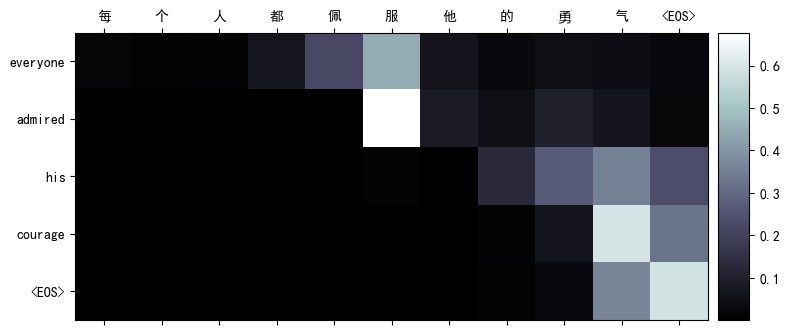


input = 祝 你 好 运
output = good luck <EOS>
ground truth = good luck


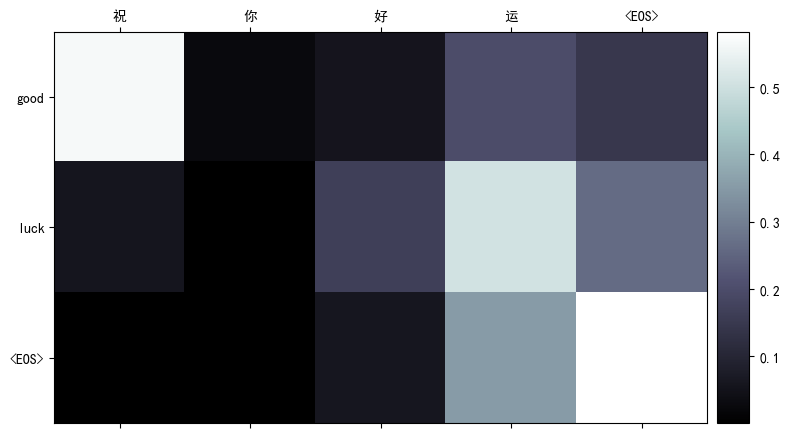

In [28]:
good = [151, 225, 278, 340, 375, 204, 2, 2926]
bad = [571, 1160, 1245, 1044, 1340]

for idx in range(len(good)):
    if idx == len(good)-1 or idx == len(good)-2:
        i = str(good[idx])
        evaluateAndShowAttention(data[i][0], data[i][2], data[i][1], np.array(data[i][3]), True)
    else:
        i = str(good[idx])
        evaluateAndShowAttention(data[i][0], data[i][2], data[i][1], np.array(data[i][3]), False)
    print()

input = 我 们 试 图 让 手 指 互 相 交 错
output = we try to make mistakes <EOS>
ground truth = we kept our fingers crossed

input = 我 们 现 在 缺 乏 库 存
output = we are sitting in our downtown <EOS>
ground truth = we re out of stock now

input = 再 检 查 一 下 汤 姆 的 脉 搏
output = later tom turned down <EOS>
ground truth = check tom s pulse again

input = 他 应 该 来 的
output = he come <EOS>
ground truth = he was supposed to come


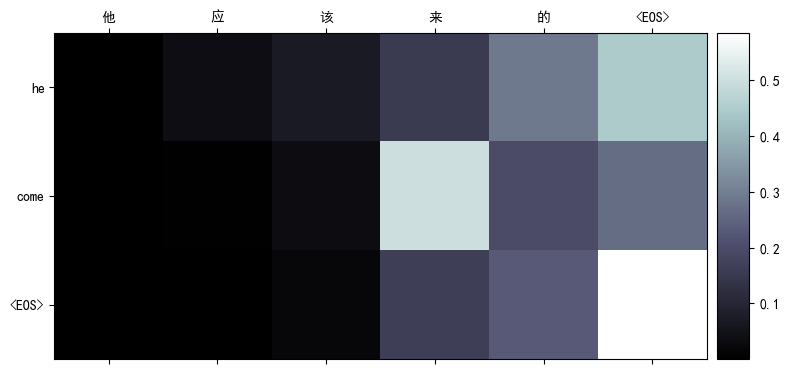


input = 我 们 可 全 靠 你 了
output = we ve keys <EOS>
ground truth = we depend on you


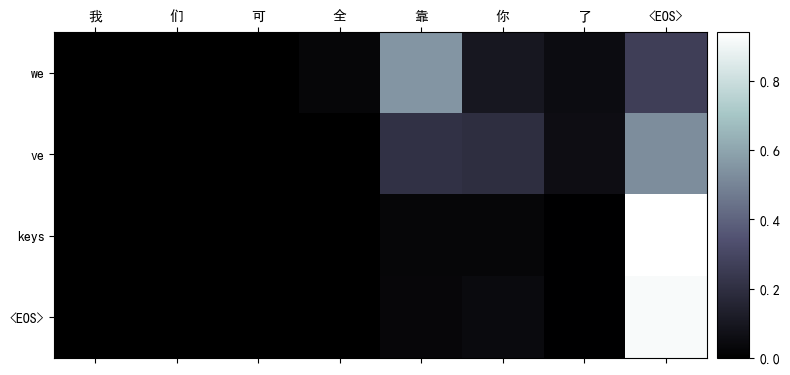

In [29]:
for idx in range(len(bad)):
    if idx == len(bad)-1 or idx == len(bad)-2:
        i = str(bad[idx])
        evaluateAndShowAttention(data[i][0], data[i][2], data[i][1], np.array(data[i][3]), True)
    else:
        i = str(bad[idx])
        evaluateAndShowAttention(data[i][0], data[i][2], data[i][1], np.array(data[i][3]), False)
    print()